In [1]:
# 0 -> 36 
%cd ..
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/sustaingym


# Wall Time per Timestep and Episode

In [2]:
import time
import numpy as np
np.random.seed(42)

from sustaingym.envs.evcharging import GMMsTraceGenerator, EVChargingEnv, RealTraceGenerator
NUM_RUNS = 100

run_time_per_1000 = {}
avg_eps_length = {}

for site in ['caltech']: #, 'jpl']:
    for action_type in ['discrete', 'continuous']:
        for project_action in [False, True]:
            for real in [True, False]:
                start = time.time()

                if real:
                    gen = RealTraceGenerator(site=site, date_period=('2019-05-01', '2019-08-31'))
                else:
                    gen = GMMsTraceGenerator(site=site, date_period=('2019-05-01', '2019-08-31'), n_components=50)

                env = EVChargingEnv(gen, action_type=action_type, project_action=project_action)

                setup_time = time.time() - start
                print(f"EVChargingEnv: site == {site}, action_type == {action_type}, project_action == {project_action}, using real traces == {real}")
                print(f"Time for imports and initializing gyms: {setup_time:.2f} s")

                all_rewards = []
                episode_length = []

                run_time_start = time.time()
                for _ in range(NUM_RUNS):
                    observation = env.reset()
                    done, rewards, episode_timesteps = False, 0., 0.

                    while not done:
                        action = env.action_space.sample()  # random action
                        observation, reward, done, info = env.step(action)

                        rewards += reward
                        episode_timesteps += 1

                    all_rewards.append(rewards)
                    episode_length.append(episode_timesteps)
                run_time = time.time() - run_time_start

                all_rewards = np.array(all_rewards)
                episode_length = np.array(episode_length)

                run_time_per_1000[(site, action_type, project_action, real)] = run_time * 1000 / np.sum(episode_length)
                avg_eps_length[(site, action_type, project_action, real)] = np.mean(episode_length)

                print(f"Run time: {run_time:.2f} s")
                print(f"Run time / episode: {run_time / NUM_RUNS:.2f} s")
                print(f"Run time / 1000 timesteps: {run_time * 1000 / np.sum(episode_length):.2f} s")
                print(f"Reward for random agent: {np.mean(all_rewards):.2f} +/- {np.std(all_rewards):.2f}")
                print(f"Episode length: {np.mean(episode_length):.2f} +/- {np.std(episode_length):.2f} timesteps\n")

                env.close()


EVChargingEnv: site == caltech, action_type == discrete, project_action == False, using real traces == True
Time for imports and initializing gyms: 12.54 s
Run time: 118.79 s
Run time / episode: 1.19 s
Run time / 1000 timesteps: 7.25 s
Reward for random agent: -16.08 +/- 18.58
Episode length: 163.84 +/- 9.11 timesteps

EVChargingEnv: site == caltech, action_type == discrete, project_action == False, using real traces == False
Time for imports and initializing gyms: 0.16 s
Run time: 114.47 s
Run time / episode: 1.14 s
Run time / 1000 timesteps: 6.98 s
Reward for random agent: -17.97 +/- 18.13
Episode length: 164.06 +/- 9.57 timesteps

EVChargingEnv: site == caltech, action_type == discrete, project_action == True, using real traces == True
Time for imports and initializing gyms: 13.11 s
Run time: 184.14 s
Run time / episode: 1.84 s
Run time / 1000 timesteps: 11.24 s
Reward for random agent: 25.58 +/- 14.45
Episode length: 163.84 +/- 9.11 timesteps

EVChargingEnv: site == caltech, action

In [3]:
import pandas as pd

idx = pd.MultiIndex.from_tuples(run_time_per_1000.keys(), names=['site', 'action_type', 'project_action', 'real_traces'])

run_times_per_1000 = pd.Series(run_time_per_1000.values(), index=idx)
avg_eps_length = pd.Series(avg_eps_length.values(), index=idx)

pd.DataFrame([run_times_per_1000, avg_eps_length])

display(run_times_per_1000)
display(avg_eps_length)

site     action_type  project_action  real_traces
caltech  discrete     False           True            7.250130
                                      False           6.977204
                      True            True           11.239038
                                      False          13.922454
         continuous   False           True            7.232652
                                      False           9.509491
                      True            True           11.670788
                                      False          13.426140
dtype: float64

site     action_type  project_action  real_traces
caltech  discrete     False           True           163.84
                                      False          164.06
                      True            True           163.84
                                      False          163.81
         continuous   False           True           163.84
                                      False          163.48
                      True            True           163.84
                                      False          163.72
dtype: float64

In [4]:
df = pd.DataFrame([run_time_per_1000, avg_eps_length], index=['run_times_per_1000', 'avg_eps_length'])
df
df.to_csv('./logs/wall_time/times.csv', index=True)

In [16]:
pd.read_csv('./logs/wall_time/times.csv', index_col=0)

,"('caltech', 'discrete', False, True)","('caltech', 'discrete', False, False)","('caltech', 'discrete', True, True)","('caltech', 'discrete', True, False)","('caltech', 'continuous', False, True)","('caltech', 'continuous', False, False)","('caltech', 'continuous', True, True)","('caltech', 'continuous', True, False)"
run_times_per_1000,7.25013,6.977204,11.239038,13.922454,7.232652,9.509491,11.670788,13.42614
avg_eps_length,163.84000,164.060000,163.840000,163.810000,163.840000,163.480000,163.840000,163.72000


In [5]:
df[('caltech', 'continuous', True, True)].loc['run_times_per_1000']

11.670788138872012

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


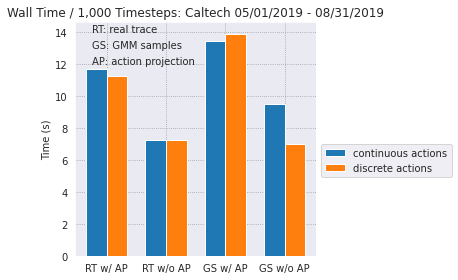

In [15]:
labels = [
    'RT w/ AP', 'RT w/o AP',
    'GS w/ AP', 'GS w/o AP',
]

run_times_cont = [
    df[('caltech', 'continuous', True, True)].loc['run_times_per_1000'],
    df[('caltech', 'continuous', False, True)].loc['run_times_per_1000'],
    df[('caltech', 'continuous', True, False)].loc['run_times_per_1000'],
    df[('caltech', 'continuous', False, False)].loc['run_times_per_1000'],

]
run_times_disc = [
    df[('caltech', 'discrete', True, True)].loc['run_times_per_1000'],
    df[('caltech', 'discrete', False, True)].loc['run_times_per_1000'],
    df[('caltech', 'discrete', True, False)].loc['run_times_per_1000'],
    df[('caltech', 'discrete', False, False)].loc['run_times_per_1000'],
]

x = np.arange(4)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, run_times_cont, width, label='continuous actions')
rects2 = ax.bar(x + width/2, run_times_disc, width, label='discrete actions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('Wall Time / 1,000 Timesteps: Caltech 05/01/2019 - 08/31/2019')
ax.set_xticks(x, labels)
ax.legend(bbox_to_anchor=[1, 0.5])

ax.annotate('RT: real trace', xy=[-0.25, 14])
ax.annotate('GS: GMM samples', xy=[-0.25, 13])
ax.annotate('AP: action projection', xy=[-0.25, 12])

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()